In [57]:

from roboflow import Roboflow
rf = Roboflow(api_key="1yy5NqkETqxKpLW9Nyou")
project = rf.workspace("dp-qvshn").project("anomaly-detection-f6l9y")
version = project.version(3)
dataset = version.download("florence2-od")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Anomaly-detection-3 in florence2-od:: 100%|██████████| 1473/1473 [00:00<00:00, 2327.63it/s]


In [10]:

import os

import json

from torch.utils.data import Dataset, DataLoader

from typing import List, Dict, Any, Tuple
from PIL import Image


In [11]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [59]:
BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

test_dataset = DetectionDataset(
    jsonl_file_path = f"Anomaly-detection-3/train/annotations.jsonl",
    image_directory_path = f"Anomaly-detection-3/train/"
)

train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)

val_dataset = DetectionDataset(
    jsonl_file_path = f"Anomaly-detection-3/valid/annotations.jsonl",
    image_directory_path = f"Anomaly-detection-3/valid/"
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
     
     

In [60]:
import torch
import re
import numpy as np
import supervision as sv

from transformers import AutoModelForCausalLM, AutoProcessor
from datasets import load_dataset

# Set device (ensure you have a CUDA-enabled GPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model and processor setup
# model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)
# processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

model= AutoModelForCausalLM.from_pretrained("allmodel", trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)
processor = AutoProcessor.from_pretrained("allmodel", trust_remote_code=True)

# Define the class extraction pattern
# Modify the pattern to match class names
# Modify the pattern to match person-related classes and also 'gun'
PATTERN = r'person[-_a-zA-Z0-9]+|gun'

def extract_classes(dataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

# Extract classes from the dataset
CLASSES = extract_classes(test_dataset)
print(CLASSES)  # To see the extracted classes

targets = []
predictions = []

# Loop over the validation dataset
for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    suffix = data['suffix']

    # Convert input to half precision
    inputs = processor(text='<OD>', images=image, return_tensors="pt").to('cuda', torch.float16)
    
    # Generate prediction using the model
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Process the generated prediction
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # Check if prediction contains valid bounding boxes
    if prediction.xyxy.shape[0] > 0:  # Ensure there are bounding boxes
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]  # Filter based on class names
        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))  # Set confidence to 1
    else:
        print(f"No objects detected in prediction for image {i}")

    # Process the target (convert from dictionary to Detections)
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    print(target)  # Check the content of 'target'

    # Convert target dictionary to Detections object
    if target.get('<OD>') and 'bboxes' in target['<OD>']:
        target_bboxes = np.array(target['<OD>']['bboxes'], dtype=np.float32)
        target_labels = np.array(target['<OD>']['labels'])
        
        # Ensure that target_bboxes is a valid 2D array with shape (n, 4)
        if target_bboxes.size == 0:  # If target_bboxes is empty, skip this target
            print(f"No bounding boxes found for target in image {i}")
            continue

        if target_bboxes.ndim == 1:
            target_bboxes = target_bboxes.reshape(1, 4)  # Reshape to (1, 4) if it's a single bounding box

        target = sv.Detections(xyxy=target_bboxes, class_id=np.array([CLASSES.index(label) for label in target_labels]),
                               confidence=np.ones(len(target_labels)), data={'class_name': target_labels})

    else:
        print(f"No bounding boxes found for target in image {i}")
        continue

    # Append target and prediction to the lists
    targets.append(target)
    predictions.append(prediction)

# Before computing mAP, let's print the first target and prediction to check their structures
print(f"First target structure: {targets[0]}")
print(f"First prediction structure: {predictions[0]}")

# After processing all targets and predictions, compute mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

['gun', 'person-holding-gun', 'person-lying', 'person-running', 'person_standing']
{'<OD>': {'bboxes': [[175.1999969482422, 88.68000030517578, 230.55999755859375, 182.27999877929688], [251.67999267578125, 131.63999938964844, 289.44000244140625, 208.44000244140625]], 'labels': ['person_standing', 'person_standing']}}
{'<OD>': {'bboxes': [[167.1999969482422, 70.68000030517578, 201.75999450683594, 128.27999877929688], [208.79998779296875, 126.5999984741211, 277.2799987792969, 209.1599884033203], [72.15999603271484, 96.1199951171875, 121.43999481201172, 210.59999084472656]], 'labels': ['person_standing', 'person_standing', 'person_standing']}}
No objects detected in prediction for image 2
{'<OD>': {'bboxes': [], 'labels': []}}
No bounding boxes found for target in image 2
{'<OD>': {'bboxes': [[149.59999084472656, 46.68000030517578, 185.1199951171875, 110.27999877929688], [184.1599884033203, 47.39999771118164, 226.0800018310547, 110.75999450683594]], 'labels': ['person_standing', 'person_st

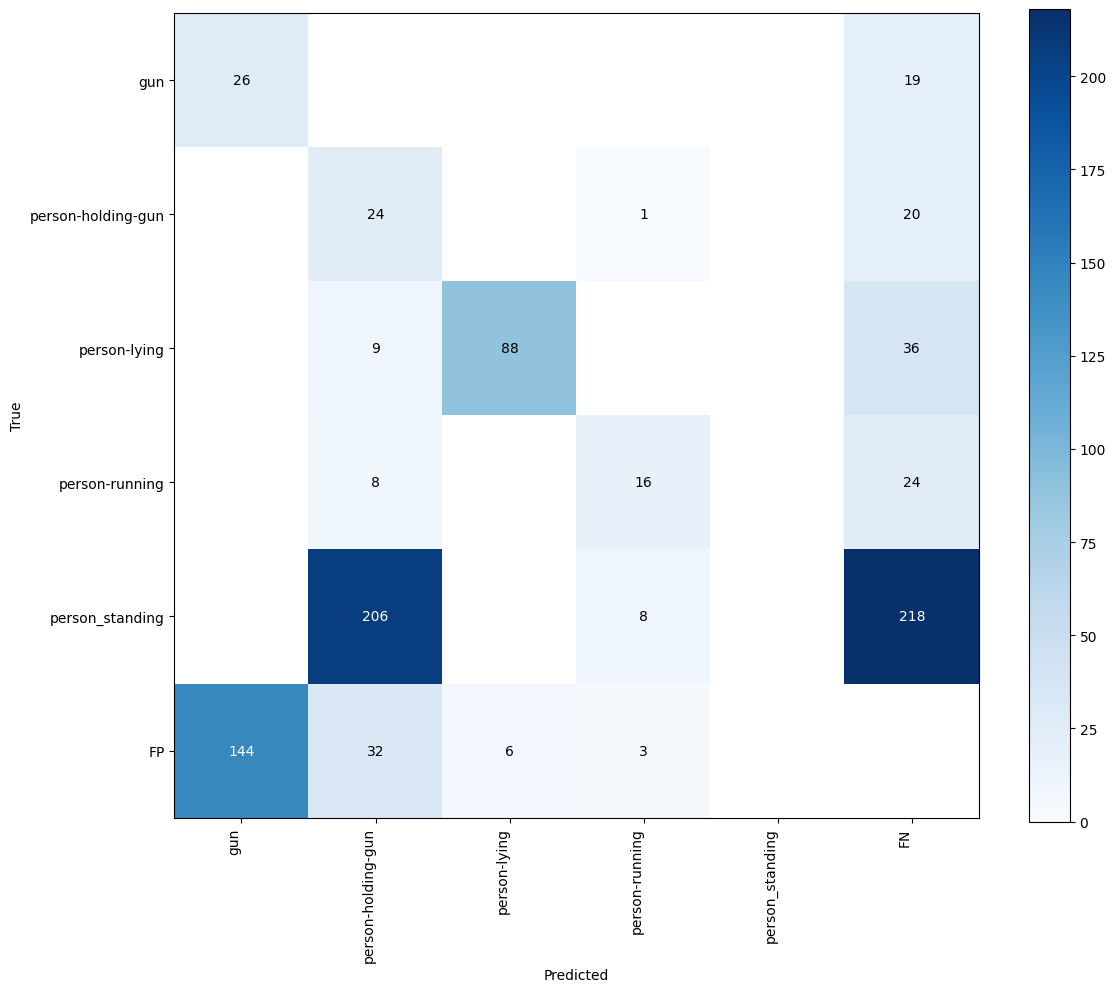

In [63]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot confusion matrix
_ = confusion_matrix.plot()


In [64]:
import torch
import re
import numpy as np
import supervision as sv

from transformers import AutoModelForCausalLM, AutoProcessor
from datasets import load_dataset

# Set device (ensure you have a CUDA-enabled GPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model and processor setup
# model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)
# processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

model= AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

# Define the class extraction pattern
# Modify the pattern to match class names
# Modify the pattern to match person-related classes and also 'gun'
PATTERN = r'person[-_a-zA-Z0-9]+|gun'

def extract_classes(dataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

# Extract classes from the dataset
CLASSES = extract_classes(test_dataset)
print(CLASSES)  # To see the extracted classes

targets = []
predictions = []

# Loop over the validation dataset
for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    suffix = data['suffix']

    # Convert input to half precision
    inputs = processor(text='<OD>', images=image, return_tensors="pt").to('cuda', torch.float16)
    
    # Generate prediction using the model
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Process the generated prediction
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # Check if prediction contains valid bounding boxes
    if prediction.xyxy.shape[0] > 0:  # Ensure there are bounding boxes
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]  # Filter based on class names
        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))  # Set confidence to 1
    else:
        print(f"No objects detected in prediction for image {i}")

    # Process the target (convert from dictionary to Detections)
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    print(target)  # Check the content of 'target'

    # Convert target dictionary to Detections object
    if target.get('<OD>') and 'bboxes' in target['<OD>']:
        target_bboxes = np.array(target['<OD>']['bboxes'], dtype=np.float32)
        target_labels = np.array(target['<OD>']['labels'])
        
        # Ensure that target_bboxes is a valid 2D array with shape (n, 4)
        if target_bboxes.size == 0:  # If target_bboxes is empty, skip this target
            print(f"No bounding boxes found for target in image {i}")
            continue

        if target_bboxes.ndim == 1:
            target_bboxes = target_bboxes.reshape(1, 4)  # Reshape to (1, 4) if it's a single bounding box

        target = sv.Detections(xyxy=target_bboxes, class_id=np.array([CLASSES.index(label) for label in target_labels]),
                               confidence=np.ones(len(target_labels)), data={'class_name': target_labels})

    else:
        print(f"No bounding boxes found for target in image {i}")
        continue

    # Append target and prediction to the lists
    targets.append(target)
    predictions.append(prediction)

# Before computing mAP, let's print the first target and prediction to check their structures
print(f"First target structure: {targets[0]}")
print(f"First prediction structure: {predictions[0]}")

# After processing all targets and predictions, compute mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

['gun', 'person-holding-gun', 'person-lying', 'person-running', 'person_standing']
{'<OD>': {'bboxes': [[175.1999969482422, 88.68000030517578, 230.55999755859375, 182.27999877929688], [251.67999267578125, 131.63999938964844, 289.44000244140625, 208.44000244140625]], 'labels': ['person_standing', 'person_standing']}}
{'<OD>': {'bboxes': [[167.1999969482422, 70.68000030517578, 201.75999450683594, 128.27999877929688], [208.79998779296875, 126.5999984741211, 277.2799987792969, 209.1599884033203], [72.15999603271484, 96.1199951171875, 121.43999481201172, 210.59999084472656]], 'labels': ['person_standing', 'person_standing', 'person_standing']}}
{'<OD>': {'bboxes': [], 'labels': []}}
No bounding boxes found for target in image 2
{'<OD>': {'bboxes': [[149.59999084472656, 46.68000030517578, 185.1199951171875, 110.27999877929688], [184.1599884033203, 47.39999771118164, 226.0800018310547, 110.75999450683594]], 'labels': ['person_standing', 'person_standing']}}
{'<OD>': {'bboxes': [[163.039993286

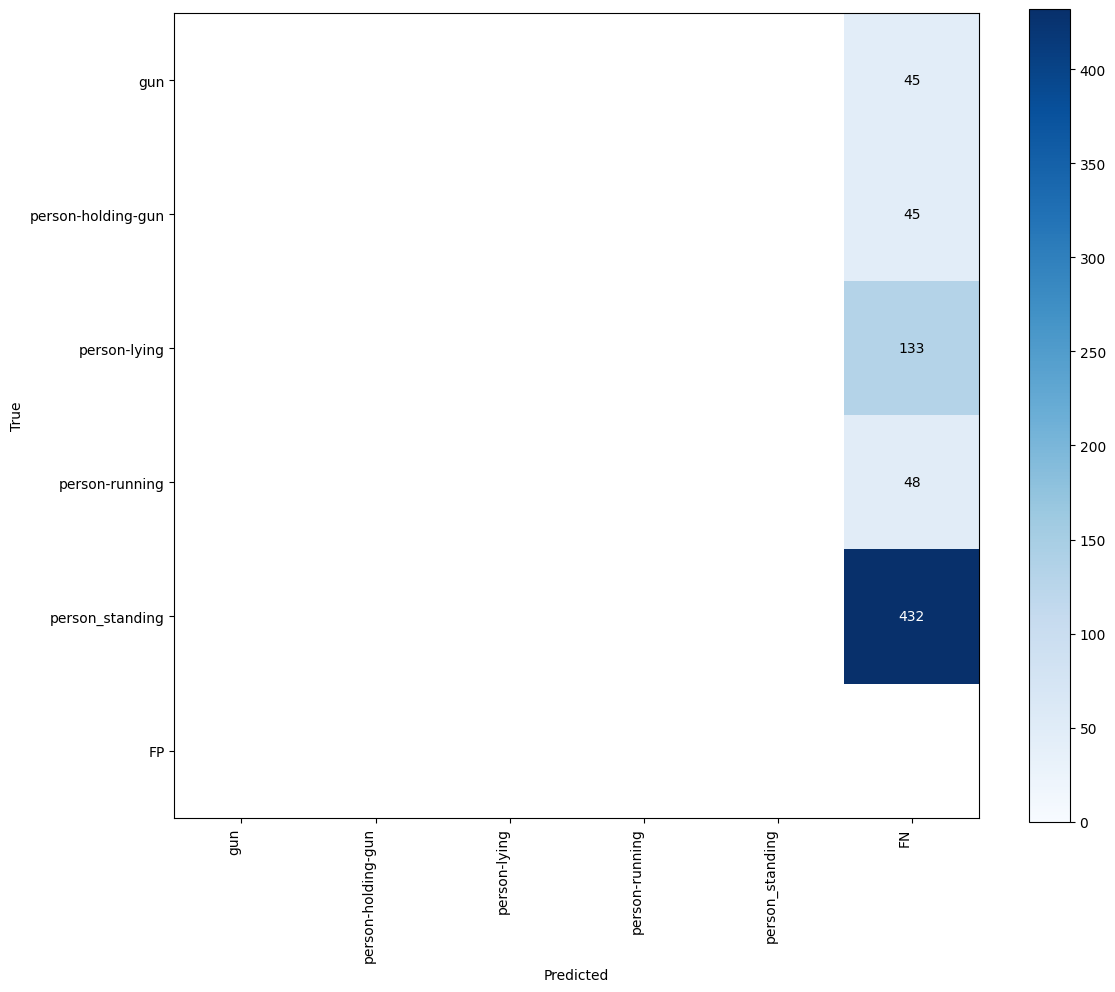

In [65]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot confusion matrix
_ = confusion_matrix.plot()